<a href="https://colab.research.google.com/github/somtirthadas/ComputerNetworks/blob/main/attention_mechanism_image_captioning_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [2]:
# Create the directory if it doesn't exist
import os
dir_path = '/content/flickr8k'
os.makedirs(dir_path, exist_ok=True)

print(f"Directory created at: {dir_path}")
# Download the dataset
!kaggle datasets download -d adityajn105/flickr8k -p /content/flickr8k

# Extract the dataset
import zipfile
with zipfile.ZipFile('/content/flickr8k/flickr8k.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/flickr8k')

print("Dataset downloaded and extracted!")

Directory created at: /content/flickr8k
Dataset URL: https://www.kaggle.com/datasets/adityajn105/flickr8k
License(s): CC0-1.0
 98% 1.02G/1.04G [00:04<00:00, 232MB/s]
100% 1.04G/1.04G [00:04<00:00, 250MB/s]
Dataset downloaded and extracted!


In [3]:

import pandas as pd
import os

# Note: Ensure the Flickr8k dataset is uploaded to /content/flickr8k in Google Colab.
# Alternatively, you can download it from Kaggle using the Kaggle API.

# List files in the directory to confirm
!ls /content/flickr8k


captions.txt  flickr8k.zip  Images


In [4]:

# Uncomment and run this cell if you need to mount Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

# Set data location path
data_location = "/content/flickr8k"
# Ensure the data is uploaded to this directory or use the Kaggle API to download


In [ ]:

# import pandas as pd
# import os

# # Note: Ensure the Flickr8k dataset is uploaded to /content/flickr8k in Google Colab.
# # Alternatively, you can download it from Kaggle using the Kaggle API.

# # List files in the directory to confirm
# !ls /content/flickr8k


__notebook_source__.ipynb


In [5]:
df=pd.read_csv(data_location+"/captions.txt")

In [6]:
df.head()

image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...

In [7]:
import os
from collections import Counter
import spacy
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader,Dataset
import torchvision.transforms as T

from PIL import Image

In [8]:
spacy_eng = spacy.load("en_core_web_sm")

In [9]:
class Vocab:
    def __init__(self,threshold_freq):
        #setting the pre-reserved tokens int to string tokens
        self.itos = {0:"<PAD>",1:"<SOS>",2:"<EOS>",3:"<UNK>"}

        #string to int tokens
        #its reverse dict self.itos
        self.stoi = {v:k for k,v in self.itos.items()}

        self.freq_threshold = threshold_freq

    def __len__(self): return len(self.itos)

    @staticmethod
    def tokenize(text):
        return [token.text.lower() for token in spacy_eng.tokenizer(text)]

    def build_vocab(self, sentence_list):
        frequencies = Counter()
        idx = 4

        for sentence in sentence_list:
            for word in self.tokenize(sentence):
                frequencies[word] += 1

                #add the word to the vocab if it reaches minum frequecy threshold
                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

    def numericalize(self,text):
        tokenized_text = self.tokenize(text)
        return [ self.stoi[token] if token in self.stoi else self.stoi["<UNK>"] for token in tokenized_text ]

In [10]:
class flickrdataset(Dataset):
    def __init__(self,root_dir,captions_file,transform=None,frequency_threshold=5):
        self.root_dir=root_dir
        self.df=pd.read_csv(captions_file)
        self.transform=transform
        self.imgs=self.df["image"]
        self.captions=self.df["caption"]

        self.vocab = Vocab(frequency_threshold)
        self.vocab.build_vocab(self.captions.tolist())
    def __len__(self):
        return len(self.df)
    def __getitem__(self,idx):
        captions=self.captions[idx]
        images=self.imgs[idx]
        img=Image.open(self.root_dir+"/"+images).convert("RGB")
        if self.transform:
            img=self.transform(img)
        cap_vec=[]
        cap_vec+=[self.vocab.stoi["<SOS>"]]
        cap_vec+=self.vocab.numericalize(captions)
        cap_vec+=[self.vocab.stoi["<EOS>"]]
        return img,torch.tensor(cap_vec)

In [11]:
transforms=T.Compose([T.Resize(256),
    T.RandomCrop(224),
    T.ToTensor()
    #T.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
                     ]
                    )

In [12]:
import matplotlib.pyplot as plt
def show_image(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

In [13]:
dataset =  flickrdataset(
    root_dir = data_location+"/Images",
    captions_file = data_location+"/captions.txt",
    transform=transforms
)

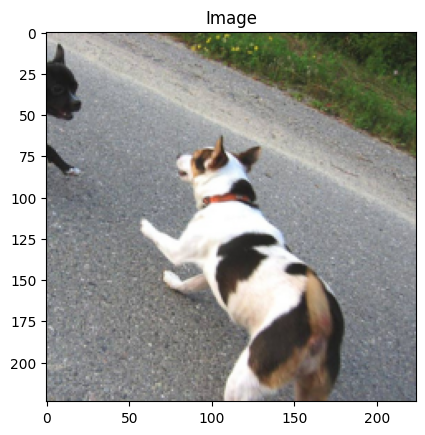

Token: tensor([  1,   4,  20,   6,  16,   4, 680,   6,  34, 694,   2])
Sentence:
['<SOS>', 'a', 'black', 'dog', 'and', 'a', 'spotted', 'dog', 'are', 'fighting', '<EOS>']


In [14]:
img,cap=dataset[5]
show_image(img,"Image")
print("Token:",cap)
print("Sentence:")
print([dataset.vocab.itos[token] for token in cap.tolist()])

In [15]:
import numpy as np

In [16]:
BATCH_SIZE = 256
NUM_WORKER = 1

#token to represent the padding
pad_idx = dataset.vocab.stoi["<PAD>"]
from torch.utils.data.sampler import SubsetRandomSampler
def collate_function(batch):

    imgs = [item[0].unsqueeze(0) for item in batch]
    imgs = torch.cat(imgs,dim=0)
    targets = [item[1] for item in batch]
    targets = pad_sequence(targets, batch_first=True, padding_value=dataset.vocab.stoi["<PAD>"])
    return imgs,targets

validation_split = .2
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE,
                                           sampler=train_sampler,num_workers=NUM_WORKER,collate_fn=collate_function)
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE,
                                                sampler=valid_sampler,num_workers=NUM_WORKER,collate_fn=collate_function)


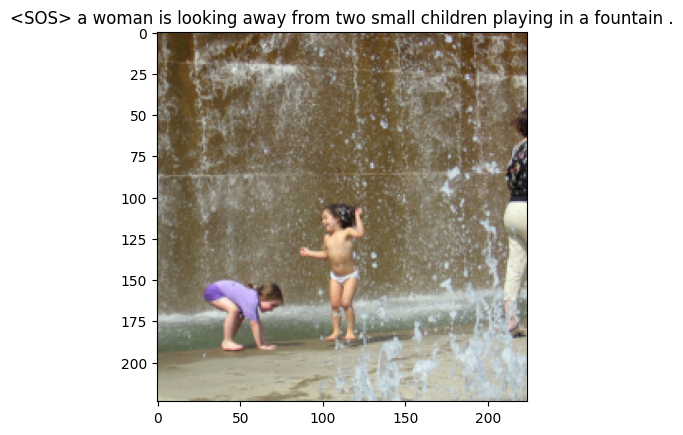

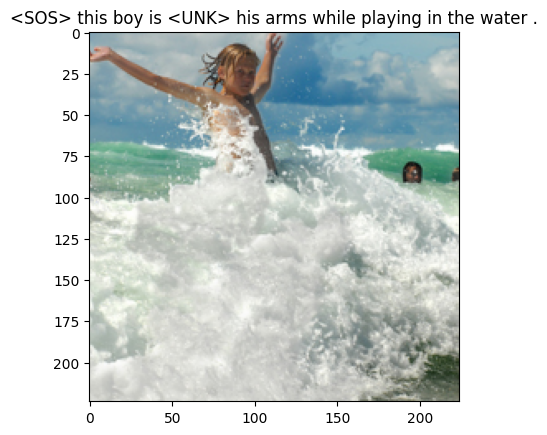

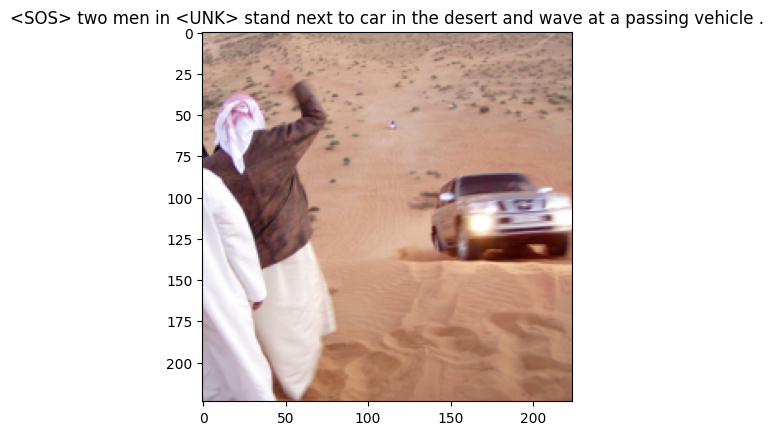

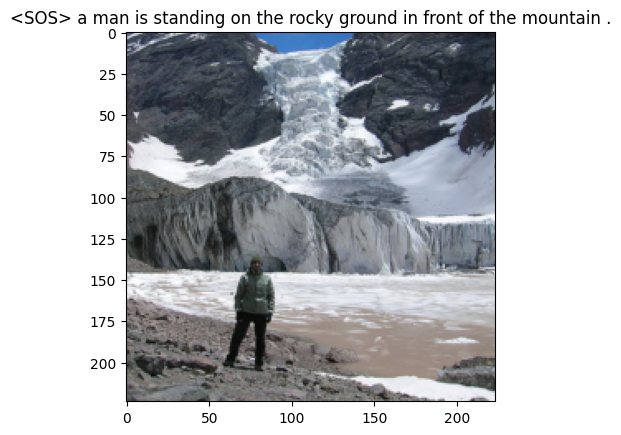

In [17]:
dataiter=next(iter(train_loader))
images, captions_ = dataiter
for k in range(4):
    img,captions=images[k],captions_[k]
    show_image(img," ".join([dataset.vocab.itos[token] for token in captions.tolist() if token!=dataset.vocab.stoi["<EOS>"]and token!=dataset.vocab.stoi["<PAD>"]]))
    plt.show()

In [18]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim

In [19]:
class EncoderCNN(nn.Module):
    def __init__(self):
        super(EncoderCNN,self).__init__()
        resnet=models.resnet50(pretrained=True)
        for p in resnet.parameters():
            p.requires_grad_(False)
        modules=list(resnet.children())[:-2]
        self.resnet=nn.Sequential(*modules)
    def forward(self,images):
        features=self.resnet(images)
        features=features.permute(0,2,3,1)
        features=features.view(features.size(0),-1,features.size(-1))
        return features #(batch_size,49,2048)


In [20]:
class BahadnauAttention(nn.Module):
    def __init__(self):
        super(BahadnauAttention,self).__init__()
        self.U=nn.Linear(512,512)
        self.W=nn.Linear(2048,512)
        self.v=nn.Linear(512,1)
        self.tanh=nn.Tanh()
        self.softmax=nn.Softmax(1)

    def forward(self,features,hidden_states):
        U_hidden=self.U(hidden_states)#(batch_size,512)
        W_features=self.W(features)#(batch_size,49,512)
        attention=self.tanh(U_hidden.unsqueeze(1)+W_features)
        e=self.v(attention).squeeze(2) #(batch_size,1)
        alpha=self.softmax(e)
        context=(features*alpha.unsqueeze(2)).sum(1)
        return alpha,context

In [21]:
class DecoderRNN(nn.Module):
    def __init__(self,embed_size, vocab_size, attention_dim,encoder_dim,decoder_dim,drop_prob=0.3):
        super().__init__()

        #save the model param
        self.vocab_size = vocab_size
        self.attention_dim = attention_dim
        self.decoder_dim = decoder_dim

        self.embedding = nn.Embedding(vocab_size,embed_size)
        self.attention = BahadnauAttention()


        self.init_h = nn.Linear(encoder_dim, decoder_dim)
        self.init_c = nn.Linear(encoder_dim, decoder_dim)
        self.lstm_cell = nn.LSTMCell(embed_size+encoder_dim,decoder_dim,bias=True)
        self.f_beta = nn.Linear(decoder_dim, encoder_dim)


        self.fcn = nn.Linear(decoder_dim,vocab_size)
        self.drop = nn.Dropout(drop_prob)



    def forward(self, features, captions):

        #vectorize the caption
        embeds = self.embedding(captions)

        # Initialize LSTM state
        h, c = self.init_hidden_state(features)  # (batch_size, decoder_dim)

        #get the seq length to iterate
        seq_length = len(captions[0])-1 #Exclude the last one
        batch_size = captions.size(0)
        num_features = features.size(1)

        preds = torch.zeros(batch_size, seq_length, self.vocab_size).to(device)
        alphas = torch.zeros(batch_size, seq_length,num_features).to(device)

        for s in range(seq_length):
            alpha,context = self.attention(features, h)
            lstm_input = torch.cat((embeds[:, s], context), dim=1)
            h, c = self.lstm_cell(lstm_input, (h, c))

            output = self.fcn(self.drop(h))

            preds[:,s] = output
            alphas[:,s] = alpha


        return preds, alphas

    def generate_caption(self,features,max_len=20,vocab=None):
        # Inference part
        # Given the image features generate the captions

        batch_size = features.size(0)
        h, c = self.init_hidden_state(features)  # (batch_size, decoder_dim)

        alphas = []

        #starting input
        word = torch.tensor(vocab.stoi['<SOS>']).view(1,-1).to(device)
        embeds = self.embedding(word)


        captions = []

        for i in range(max_len):
            alpha,context = self.attention(features, h)


            #store the apla score
            alphas.append(alpha.cpu().detach().numpy())

            lstm_input = torch.cat((embeds[:, 0], context), dim=1)
            h, c = self.lstm_cell(lstm_input, (h, c))
            output = self.fcn(self.drop(h))
            output = output.view(batch_size,-1)


            #select the word with most val
            predicted_word_idx = output.argmax(dim=1)

            #save the generated word
            captions.append(predicted_word_idx.item())

            #end if <EOS detected>
            if vocab.itos[predicted_word_idx.item()] == "<EOS>":
                break

            #send generated word as the next caption
            embeds = self.embedding(predicted_word_idx.unsqueeze(0))

        #covert the vocab idx to words and return sentence
        return [vocab.itos[idx] for idx in captions],alphas


    def init_hidden_state(self, encoder_out):
        mean_encoder_out = encoder_out.mean(dim=1)
        h = self.init_h(mean_encoder_out)  # (batch_size, decoder_dim)
        c = self.init_c(mean_encoder_out)
        return h, c

In [22]:
class EncoderDecoder(nn.Module):
    def __init__(self,embed_size, vocab_size, attention_dim,encoder_dim,decoder_dim,drop_prob=0.3):
        super().__init__()
        self.encoder = EncoderCNN()
        self.decoder = DecoderRNN(
            embed_size=embed_size,
            vocab_size = len(dataset.vocab),
            attention_dim=attention_dim,
            encoder_dim=encoder_dim,
            decoder_dim=decoder_dim
        )

    def forward(self, images, captions):
        features = self.encoder(images)
        outputs = self.decoder(features, captions)
        return outputs

In [23]:
embed_size=300
vocab_size = len(dataset.vocab)
attention_dim=256
encoder_dim=2048
decoder_dim=512
learning_rate = 3e-4

In [24]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [25]:
model = EncoderDecoder(
    embed_size=300,
    vocab_size = len(dataset.vocab),
    attention_dim=256,
    encoder_dim=2048,
    decoder_dim=512
).to(device)
#print(type(torch.load("../input/load-model/attention_model_state_100.pth")))
#model.load_state_dict(torch.load("../input/load-model/attention_model_state_100.pth")["state_dict"])
criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 144MB/s]


In [26]:
def save_model(model,num_epochs):
    model_state = {
        'num_epochs':num_epochs,
        'embed_size':embed_size,
        'vocab_size':len(dataset.vocab),
        'attention_dim':attention_dim,
        'encoder_dim':encoder_dim,
        'decoder_dim':decoder_dim,
        'state_dict':model.state_dict()
    }

    torch.save(model_state,'attention_model_state.pth')

Epoch: 1 loss: 4.28728


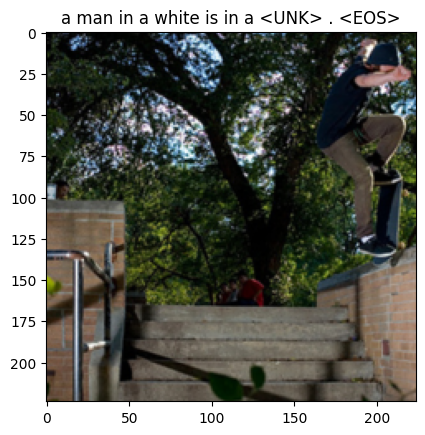

Epoch: 2 loss: 3.72716


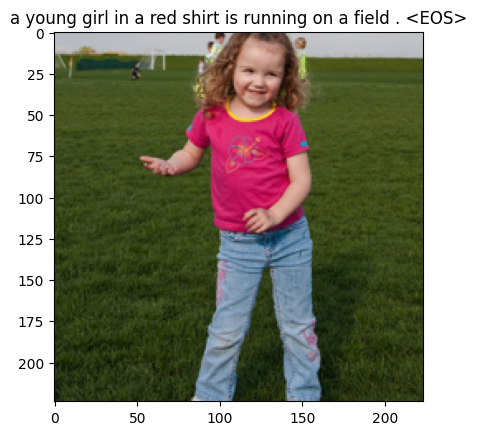

Epoch: 3 loss: 3.34300


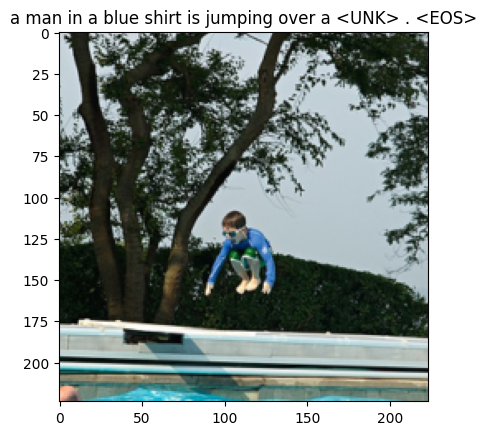

Epoch: 4 loss: 3.17258


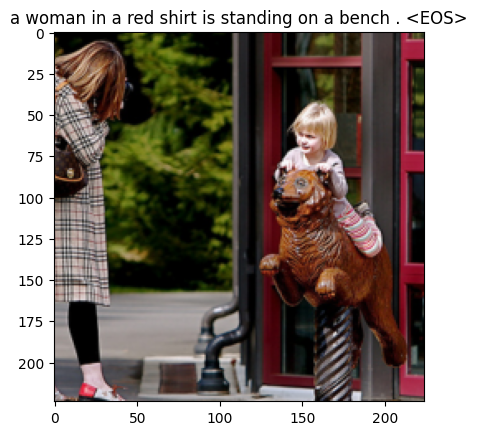

Epoch: 5 loss: 3.03350


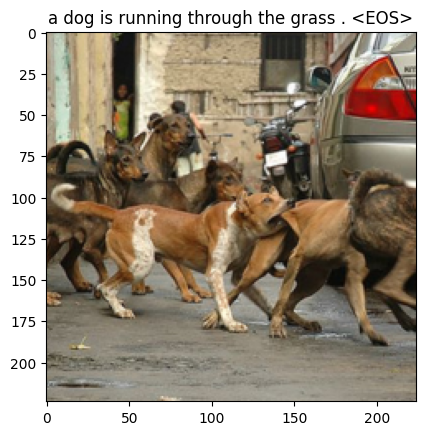

Epoch: 6 loss: 2.96238


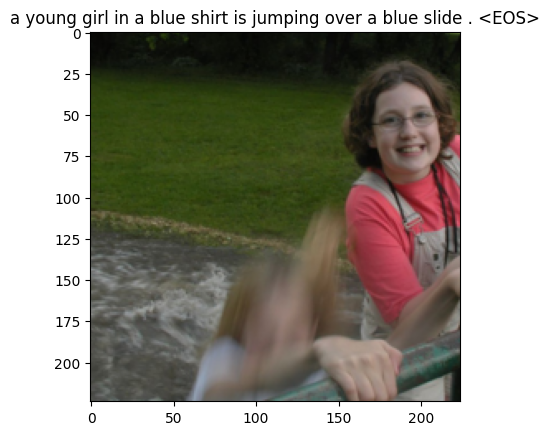

Epoch: 7 loss: 2.86637


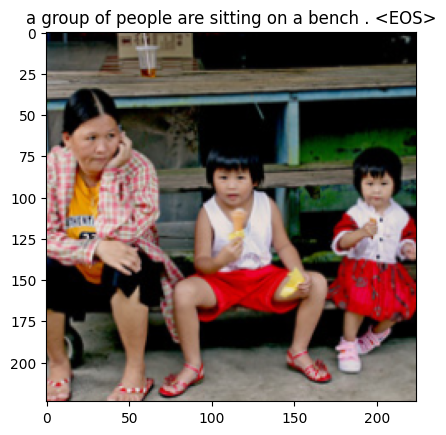

Epoch: 8 loss: 2.64425


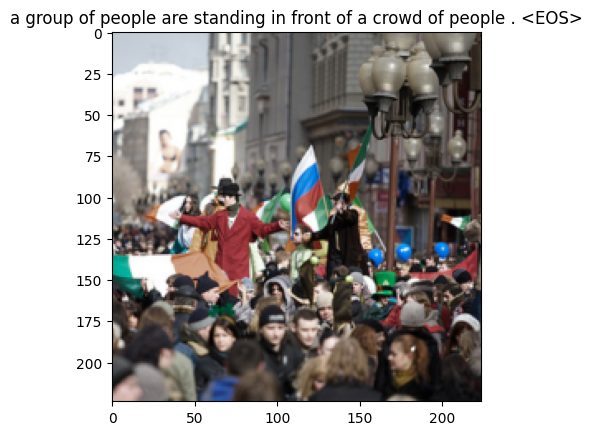

Epoch: 9 loss: 2.70445


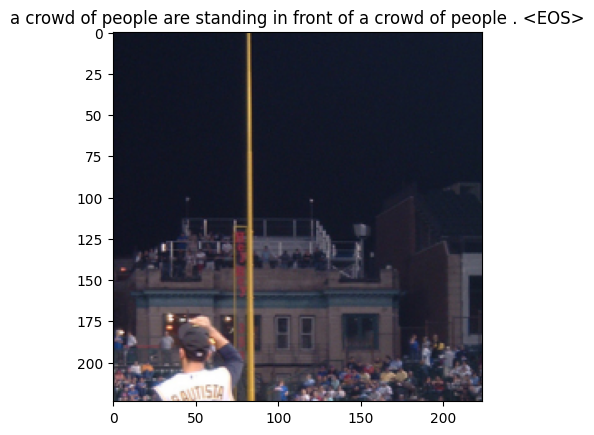

Epoch: 10 loss: 2.69908


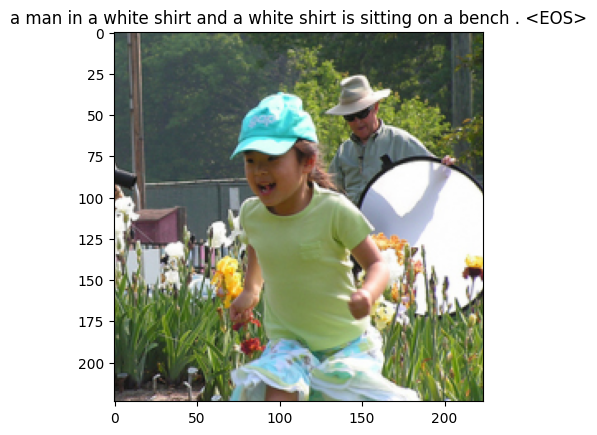

In [28]:
num_epochs = 10
print_every = 100
losses=[]
for epoch in range(1,num_epochs+1):
    losses_per_epoch=0
    for idx, (image, captions) in enumerate(iter(train_loader)):
        image,captions = image.to(device),captions.to(device)
        optimizer.zero_grad()
        outputs,attentions = model(image, captions)
        targets = captions[:,1:]
        loss = criterion(outputs.view(-1, vocab_size), targets.reshape(-1))
        losses_per_epoch+=loss.item()
        loss.backward()

        # Update the parameters in the optimizer.
        optimizer.step()

        if (idx+1)%print_every == 0:
            print("Epoch: {} loss: {:.5f}".format(epoch,loss.item()))


            #generate the caption
            model.eval()
            with torch.no_grad():
                dataiter = iter(validation_loader)
                img,_ = next(dataiter)
                features = model.encoder(img[0:1].to(device))
                caps,alphas = model.decoder.generate_caption(features,vocab=dataset.vocab)
                caption = ' '.join(caps)
                show_image(img[0],title=caption)

            model.train()
    losses.append(losses_per_epoch)
    #save the latest model
    save_model(model,epoch)

In [ ]:
 !ls

In [29]:
from IPython.display import FileLink
FileLink("attention_model_state.pth")

/content/attention_model_state.pth

torch.Size([256, 3, 224, 224])


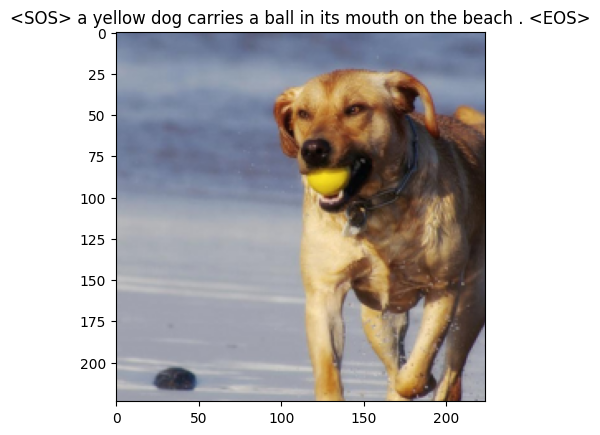

[['<SOS>', 'a', 'yellow', 'dog', 'carries', 'a', 'ball', 'in', 'its', 'mouth', 'on', 'the', 'beach', '.', '<EOS>']] ['a', 'brown', 'dog', 'is', 'running', 'in', 'the', 'snow', '.', '<EOS>']
Generated caption :  a brown dog is running in the snow . <EOS>
Bleu 1 gram score :  0.36391839582758007


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


In [30]:
#testing
import nltk
from nltk.translate.bleu_score import sentence_bleu
model.eval()
img,caption=next(iter(validation_loader))
img_=img[50]
print(img.size())
show_image(img_," ".join([dataset.vocab.itos[k] for k in caption[50].tolist() if dataset.vocab.itos[k]!="<PAD>"]))
features = model.encoder(img_.unsqueeze(0).to(device))
caps,alphas = model.decoder.generate_caption(features,vocab=dataset.vocab)
caption_ = ' '.join(caps)
reference=[[dataset.vocab.itos[k] for k in caption[50].tolist() if dataset.vocab.itos[k]!="<PAD>"]]
candidate=caps
print(reference,candidate)
score=sentence_bleu(reference,candidate,weights=(1,0,0,0))
print("Generated caption : ",caption_)
print("Bleu 1 gram score : ",score)

In [31]:
#checking corpus bleu score
from nltk.translate.bleu_score import corpus_bleu
references=[]
candidates=[]
for idx,(image,caption) in enumerate(iter(validation_loader)):
    print(image.size())
    for k in range(image.size()[0]):
        features=model.encoder(image[k].unsqueeze(0).to(device))
        caps,alpha=model.decoder.generate_caption(features,vocab=dataset.vocab)
        reference=[dataset.vocab.itos[i] for i in caption[k].tolist() if dataset.vocab.itos[i]!="<PAD>"]
        references.append(reference)
        candidates.append(caps)


torch.Size([256, 3, 224, 224])
torch.Size([256, 3, 224, 224])
torch.Size([256, 3, 224, 224])
torch.Size([256, 3, 224, 224])
torch.Size([256, 3, 224, 224])
torch.Size([256, 3, 224, 224])
torch.Size([256, 3, 224, 224])
torch.Size([256, 3, 224, 224])
torch.Size([256, 3, 224, 224])
torch.Size([256, 3, 224, 224])
torch.Size([256, 3, 224, 224])
torch.Size([256, 3, 224, 224])
torch.Size([256, 3, 224, 224])
torch.Size([256, 3, 224, 224])
torch.Size([256, 3, 224, 224])
torch.Size([256, 3, 224, 224])
torch.Size([256, 3, 224, 224])
torch.Size([256, 3, 224, 224])
torch.Size([256, 3, 224, 224])
torch.Size([256, 3, 224, 224])
torch.Size([256, 3, 224, 224])
torch.Size([256, 3, 224, 224])
torch.Size([256, 3, 224, 224])
torch.Size([256, 3, 224, 224])
torch.Size([256, 3, 224, 224])
torch.Size([256, 3, 224, 224])
torch.Size([256, 3, 224, 224])
torch.Size([256, 3, 224, 224])
torch.Size([256, 3, 224, 224])
torch.Size([256, 3, 224, 224])
torch.Size([256, 3, 224, 224])
torch.Size([155, 3, 224, 224])


In [32]:
print("bleu 1 score : ",corpus_bleu(references,candidates,weights=(1,0,0,0)))
print("bleu 2 score : ",corpus_bleu(references,candidates,weights=(0.5,0.5,0,0)))
print("bleu 3 score : ",corpus_bleu(references,candidates,weights=(0.33,0.33,0.33,0)))
print("bleu 4 score : ",corpus_bleu(references,candidates,weights=(0.25,0.25,0.25,0.25)))

/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


bleu 1 score :  0.14662888246682193
bleu 2 score :  5.711918182879262e-155
bleu 3 score :  4.721714979153109e-204
bleu 4 score :  1.1273615139190123e-231


In [33]:
def attention_plot(image,caps,alphas):
    image=image.numpy().transpose((1,2,0))
    len_result=len(caps)
    temp_image=image
    fig=plt.figure(figsize=(15,15))
    for k in range(len_result):
        temp_att=alphas[k].reshape(7,7)
        ax=fig.add_subplot(len_result//2,len_result//2,k+1)
        ax.set_title(caps[k])
        img=ax.imshow(temp_image)
        ax.imshow(temp_att,cmap="gray",alpha=0.7,extent=img.get_extent())
    plt.tight_layout()
    plt.show()

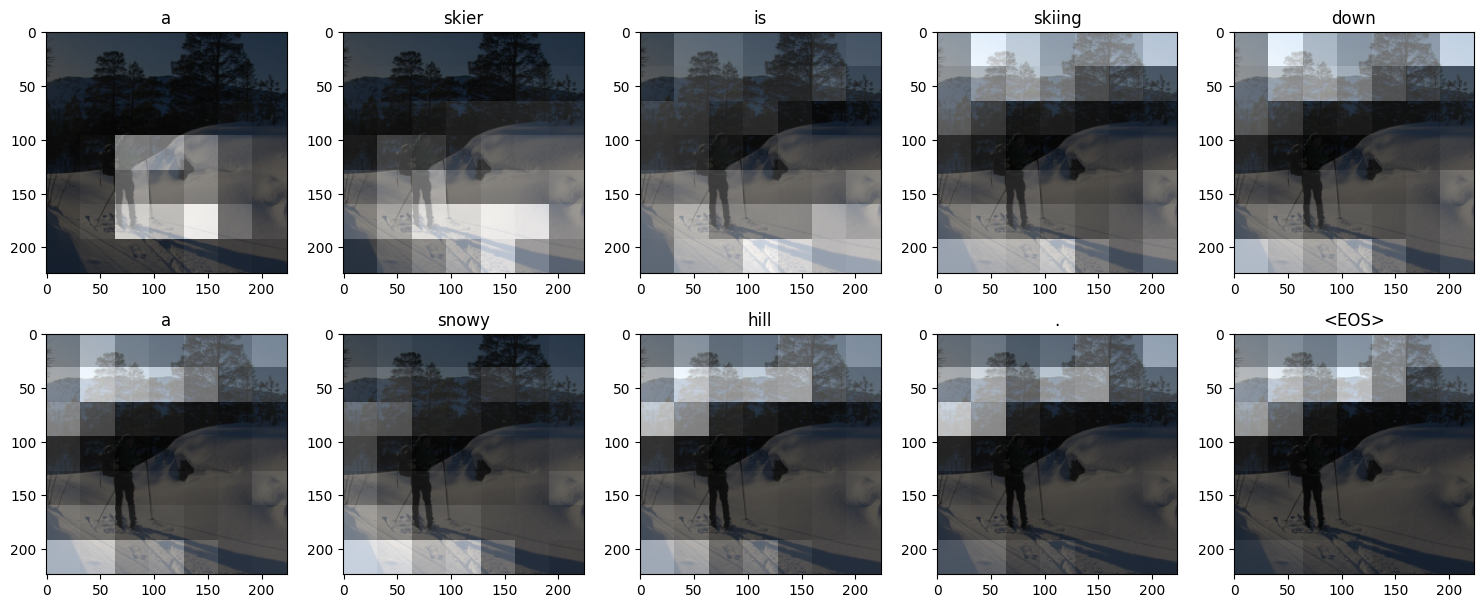

In [36]:
dataiter=iter(validation_loader)
images,_=next(dataiter)
img1=images[4].detach().clone()
features=model.encoder(img1.unsqueeze(0).to(device))
caps,alphas=model.decoder.generate_caption(features,vocab=dataset.vocab)
attention_plot(img1,caps,alphas)